<a href="https://colab.research.google.com/github/justynigam/Invsto_team_Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First install libraries and fetch data needed





In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# now Data Ingestion
tickers = ['AAPL' , 'MSFT' , 'GOOGL' , 'AMZN' , 'TSLA']
start_date = '2020-01-01'
end_date = '2023-12-31'

print(f"Downloading data for: {tickers}....")

raw_data = yf.download(tickers , start = start_date , end = end_date)

if raw_data.empty:
    raise ValueError("No data downloaded for the specified tickers and date range.")

try:

    data = raw_data['Adj Close']
    print("Success: Selected 'Adj Close' prices.")
except KeyError:

    print("'Adj Close' not found. Falling back to 'Close' prices.")
    try:
        data = raw_data['Close']
    except KeyError:
        raise KeyError(f"Neither 'Adj Close' nor 'Close' found in downloaded data for {tickers}.")


# Flatten multi-index
if isinstance(data.columns , pd.MultiIndex):
  data.columns = data.columns.droplevel(0)

#See table
print("Data Shape:" , data.shape)
data.head()

[*********************100%***********************]  5 of 5 completed

'Adj Close' not found. Falling back to 'Close' prices.
Data Shape: (1006, 5)


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2020-01-02,72.468254,94.900497,67.920807,152.505707,28.684000
2020-01-03,71.763733,93.748497,67.565491,150.606750,29.534000
2020-01-06,72.335564,95.143997,69.366386,150.996002,30.102667
2020-01-07,71.995346,95.343002,69.232399,149.619263,31.270666
2020-01-08,73.153481,94.598503,69.725174,152.002502,32.809334


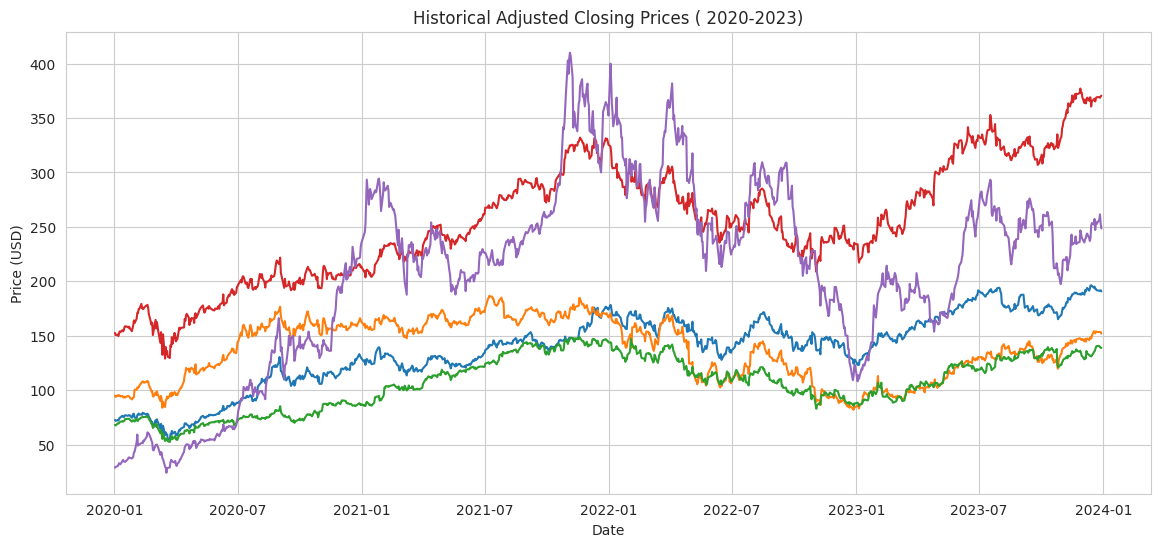

In [3]:
# Now its Data Preparation
data_clean = data.ffill().bfill()

# Then Exploratory Data Analysis
plt.figure(figsize=(14,6))
for col in data_clean.columns:
  plt.plot(data_clean.index , data_clean[col] , label=col)
plt.title('Historical Adjusted Closing Prices ( 2020-2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend
plt.show()

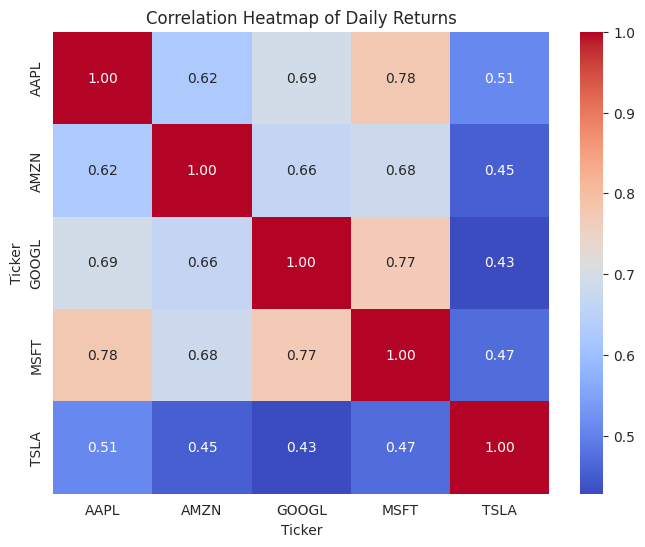

In [4]:
# Correlation Heatmap of Returns
daily_returns = data_clean.pct_change().dropna()
plt.figure(figsize=(8,6))
sns.heatmap(daily_returns.corr() , annot=True , cmap='coolwarm' , fmt=".2f")
plt.title('Correlation Heatmap of Daily Returns')
plt.show()

In [5]:
# Now check Volatility
volatility = daily_returns.std()
print("\nDaily Volatility (Risk) :")
print(volatility.sort_values(ascending=False))


Daily Volatility (Risk) :
Ticker
TSLA     0.042902
AMZN     0.023741
AAPL     0.021146
GOOGL    0.021124
MSFT     0.020546
dtype: float64


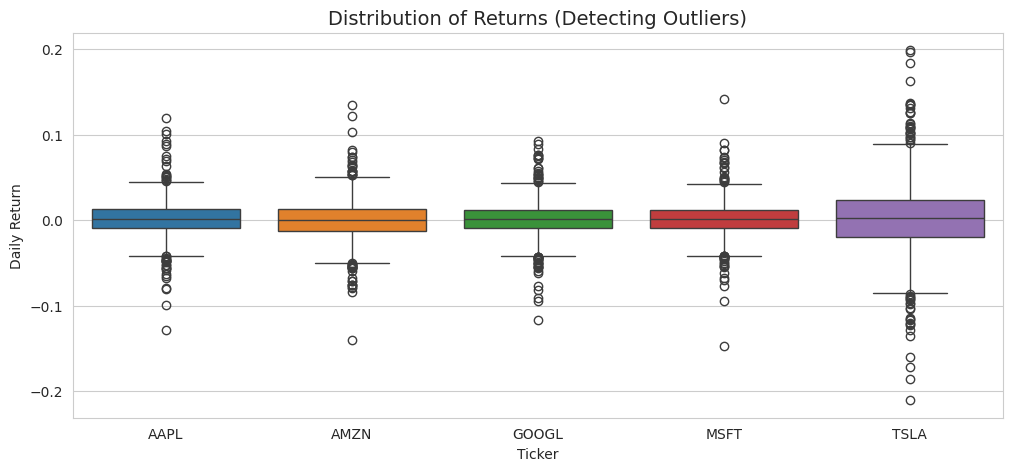

In [6]:
# Boxplot to visualize Anomalies and on outliers
plt.figure(figsize=(12, 5))
sns.boxplot(data=daily_returns)  # <--- THIS LINE CREATES THE BOXPLOT
plt.title('Distribution of Returns (Detecting Outliers)', fontsize=14)
plt.ylabel('Daily Return')
plt.show()

In [7]:
# use of Dask for maximize score

import dask.dataframe as dd
import numpy as np

print("Converting to Dask DataFrame for demonstration...")
dask_df = dd.from_pandas(data_clean, npartitions=2)

# Simple Dask Operation
dask_mean = dask_df.mean().compute()
print("\nMean Prices calculated via Dask:")
print(dask_mean)


def validate_data(df):
    """
    Checks for critical data quality issues.
    """
    # Step 1: No missing values allowed
    assert df.isnull().sum().sum() == 0, "Test Failed: Missing values detected!"

    # Step 2: Data must be numeric
    assert np.issubdtype(df.values.dtype, np.number), "Test Failed: Non-numeric data found!"

    # Step 3: Index must be Datetime
    assert pd.api.types.is_datetime64_any_dtype(df.index), "Test Failed: Index is not Datetime!"

    print("\n Data Validation Passed: Dataset is clean and valid.")

# Run the validation
try:
    validate_data(data_clean)
except AssertionError as e:
    print(f" Data Validation Failed: {e}")

Converting to Dask DataFrame for demonstration...

Mean Prices calculated via Dask:
Ticker
AAPL     138.087082
AMZN     137.216247
GOOGL    107.061321
MSFT     254.761908
TSLA     209.126371
dtype: float64

 Data Validation Passed: Dataset is clean and valid.


In [8]:
#  Feature Engineering Function
def create_features(df, target_ticker):
    df_feat = df[[target_ticker]].copy()
    df_feat.columns = ['Close']

    # Lagged features
    for lag in [1, 2, 5, 21]: # 1 day, 2 days, 1 week, 1 month
        df_feat[f'lag_{lag}'] = df_feat['Close'].shift(lag)

    # Rolling Statistics
    df_feat['rolling_mean_7'] = df_feat['Close'].rolling(window=7).mean()
    df_feat['rolling_std_7'] = df_feat['Close'].rolling(window=7).std()
    df_feat['rolling_mean_21'] = df_feat['Close'].rolling(window=21).mean()

    # Momentum (RSI-like approximation: Daily Return)
    df_feat['daily_return'] = df_feat['Close'].pct_change()

    # Target
    df_feat['Target'] = df_feat['Close'].shift(-1)

    return df_feat.dropna()


aapl_features = create_features(data_clean, 'AAPL')
aapl_features.head()

,Close,lag_1,lag_2,lag_5,lag_21,rolling_mean_7,rolling_std_7,rolling_mean_21,daily_return,Target
Date,,,,,,,,,,
2020-02-03,74.473305,74.678375,78.143135,74.543266,72.468254,76.221189,1.663828,75.354422,-0.002746,76.931938
2020-02-04,76.931938,74.473305,74.678375,76.652046,71.763733,76.239803,1.672112,75.600527,0.033014,77.559288
2020-02-05,77.559288,76.931938,74.473305,78.256554,72.335564,76.670663,1.545913,75.849275,0.008155,78.466476
2020-02-06,78.466476,77.559288,76.931938,78.143135,71.995346,76.929867,1.687867,76.157425,0.011697,77.399895
2020-02-07,77.399895,78.466476,77.559288,74.678375,73.153481,76.807487,1.604648,76.359635,-0.013593,77.767517


Training ARIMA Model...


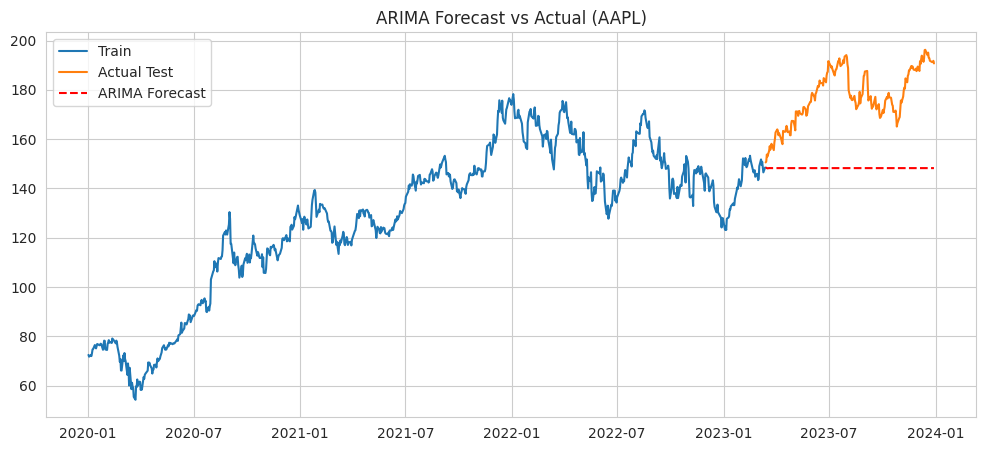

In [9]:
#  ARIMA Model
# Split data
train_size = int(len(data_clean) * 0.8)
train_data, test_data = data_clean['AAPL'][:train_size], data_clean['AAPL'][train_size:]

# Grid Search for simple ARIMA order (p,d,q) - Simplified for demo
# We assume the series needs differencing (d=1)
print("Training ARIMA Model...")
model_arima = ARIMA(train_data, order=(5,1,0))
arima_result = model_arima.fit()

# Forecast
forecast_res = arima_result.get_forecast(steps=len(test_data))
arima_pred = forecast_res.predicted_mean
arima_pred.index = test_data.index

# Plot ARIMA Results
plt.figure(figsize=(12, 5))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Actual Test')
plt.plot(arima_pred.index, arima_pred, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('ARIMA Forecast vs Actual (AAPL)')
plt.legend()
plt.show()

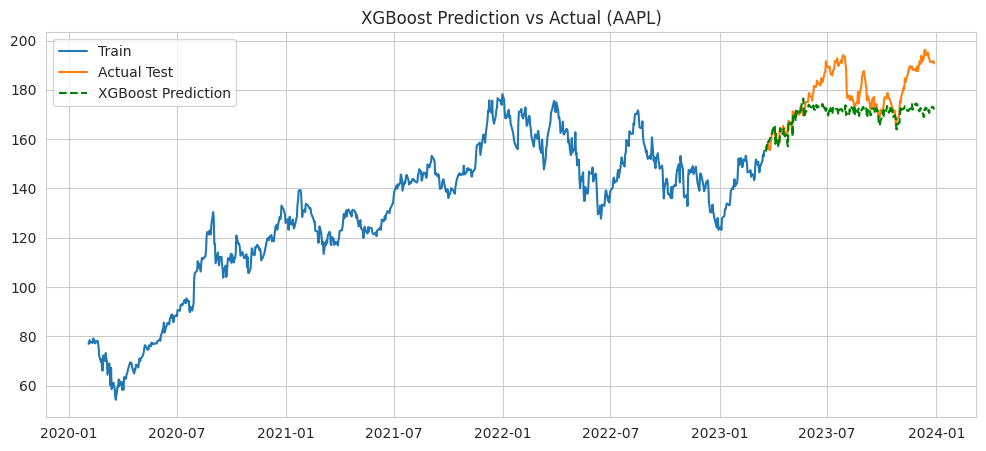

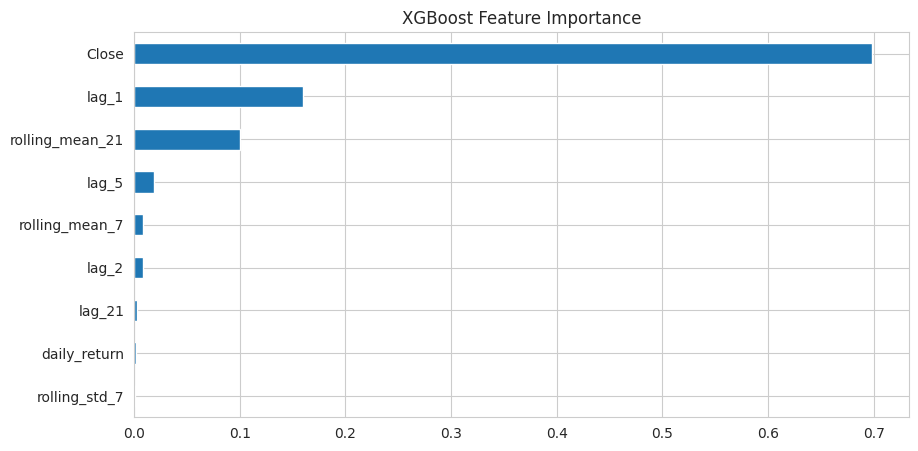

In [10]:
# Gradient Boosting (XGBoost)
X = aapl_features.drop(['Target'], axis=1)
y = aapl_features['Target']

# Split train/test (Time-series split, no shuffling!)
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Initialize and Train
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=50)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Predict
xgb_pred = xgb_model.predict(X_test)
xgb_pred_series = pd.Series(xgb_pred, index=y_test.index)

# Plot XGBoost Results
plt.figure(figsize=(12, 5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Actual Test')
plt.plot(xgb_pred_series.index, xgb_pred_series, label='XGBoost Prediction', color='green', linestyle='--')
plt.title('XGBoost Prediction vs Actual (AAPL)')
plt.legend()
plt.show()

# Feature Importance
plt.figure(figsize=(10, 5))
pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importance')
plt.show()

In [11]:
#  Evaluation Metrics
def evaluate_model(true, pred, model_name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "MAPE (%)": mape}

arima_metrics = evaluate_model(test_data, arima_pred, "ARIMA")
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost")

# Create comparison table
results_df = pd.DataFrame([arima_metrics, xgb_metrics])
print(results_df)

     Model       RMSE        MAE   MAPE (%)
0    ARIMA  30.954397  28.939121  16.003191
1  XGBoost  11.115920   8.430181   4.544628
